In [1]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import torch
import torch.optim as optim
import torch.nn as nn
import torchvision.transforms as transforms
from torch.utils.data import DataLoader
from sklearn.preprocessing import LabelEncoder
from PIL import Image
import os

In [2]:
from dataloader import DataExtractor
data_paths = DataExtractor.extract("data_zip", "data")

In [3]:
data_paths

{'Test': 'data\\Test', 'Training': 'data\\Training'}

In [4]:
paths = DataExtractor.get_internal_paths(data_paths['Training'])

In [5]:
paths

{'DepthImages': 'data\\Training\\DepthImages',
 'RGBImages': 'data\\Training\\RGBImages',
 'Train.csv': 'data\\Training\\Train.csv',
 'Training': 'data\\Training\\Training'}

In [ ]:
class GrandDiscoveryDataset(torch.utils.data.Dataset):
    def __init__(self, csv_file, root_dir, RGBImage_path: str, DepthMap_path: str, transform=None):
        # 1. Load and GLOBAL SORT by image_id
        self.df = pd.read_csv(csv_file)
        if 'image_id' in self.df.columns:
            self.df = self.df.sort_values(by='image_id').reset_index(drop=True)
            
        self.root_dir = root_dir
        self.rgb_path = RGBImage_path
        self.depth_path = DepthMap_path
        # Variety Encoding
        self.label_encoder = LabelEncoder()
        self.df['Variety_Encoded'] = self.label_encoder.fit_transform(self.df['Variety'])

    def __len__(self):
        return len(self.df)

    def __getitem__(self, idx):
        row = self.df.iloc[idx]
        img_id = str(int(row['image_id'])) 
        rgb_path = os.path.join(self.rgb_path, f"RGB_{img_id}.png")
        depth_path = os.path.join(self.depth_path, f"Depth_{img_id}.png")

        rgb_raw = Image.open(rgb_path).convert('RGB')
        depth_raw = Image.open(depth_path) # 16-bit
        
        #0.7 multiplier for compute efficiency
        orig_w, orig_h = rgb_raw.size
        target_size = (int(orig_h * 0.7), int(orig_w * 0.7)) 
        #Used Functional transforms here to handle the dynamic 70% size efficiently
        rgb_img = transforms.functional.resize(rgb_raw, target_size)
        rgb_img = transforms.functional.to_tensor(rgb_img)
        rgb_img = transforms.functional.normalize(
            rgb_img, mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225]
        )
        #Depth Processing (Raw 16-bit for training)
        depth_array = np.array(depth_raw).astype(np.float32)
        depth_tensor = torch.from_numpy(depth_array).unsqueeze(0) 
        depth_tensor = transforms.functional.resize(depth_tensor, target_size)

        #Tabular & Multi-Task Targets
        common_features = torch.tensor(row[['Height', 'Diameter']].values.astype('float32'))
        aux_targets = torch.tensor([
            row['LeafArea'],
            row['FreshWeightShoot'],
            row['Variety_Encoded']
        ], dtype=torch.float32)
        
        main_label = torch.tensor([row['DryWeightShoot']], dtype=torch.float32)

        return {
            'rgb': rgb_img,
            'depth': depth_tensor,
            'tab_in': common_features,
            'aux_targets': aux_targets,
            'label': main_label
        }

In [7]:
dataset = GrandDiscoveryDataset(paths['Train.csv'], data_paths['Training'], paths['RGBImages'], paths['DepthImages'])

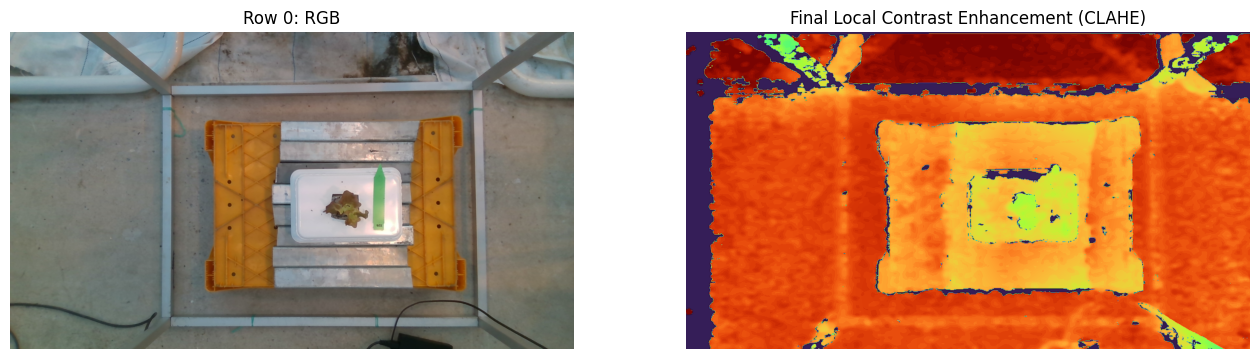

Features: [8.5, 8.199999809265137] | DryWeight: 0.1000


In [8]:
from dataloader import DataViewer

DataViewer.inspect_sample(dataset[1])

In [9]:
DataViewer.view_csv(paths['Train.csv'])

Dataset Shape: (231, 7)
------------------------------
Column Types:
image_id              int64
Height              float64
Diameter            float64
LeafArea            float64
FreshWeightShoot    float64
Variety                 str
DryWeightShoot      float64
dtype: object
------------------------------


,image_id,Height,Diameter,LeafArea,FreshWeightShoot,Variety,DryWeightShoot
0,1,8.2,12.0,80.6,2.6,Satine,0.14
1,2,8.5,8.2,67.4,2.1,Satine,0.10
2,3,7.5,9.5,65.0,2.0,Satine,0.09
3,6,8.4,13.4,107.8,3.3,Lugano,0.14
4,8,8.3,12.2,79.8,2.5,Lugano,0.10


In [10]:
len(dataset)

231